In [1]:
import pandas as pd
import numpy as np
import warnings
import os
import joblib
from time import time
warnings.filterwarnings(action='ignore')

import seaborn as sns
sns.set_palette("pastel")
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

In [2]:
os.chdir("../")
root_path = os.getcwd()

# 따옴표 안에 데이터가 있는 폴더의 상위폴더
data_folder_path = os.path.join(root_path, 'data')
original_file_path = os.path.join(data_folder_path, 'original_data')
original_raw_file_path = os.path.join(original_file_path,'raw_data')
original_processed_file_path = os.path.join(original_file_path,'processed_data')

external_file_path = os.path.join(data_folder_path,'external_data')
external_raw_file_path = os.path.join(external_file_path,'raw_data')
external_processed_file_path = os.path.join(external_file_path,'processed_data')

# Data Preprocessing
- 외식을 많이 하는 주말의 경우를 제외하고 평일의 데이터만 가지고 분석을 진행

In [3]:
mul = pd.read_excel(os.path.join(original_raw_file_path,'05_물류데이터(CJ올리브네트웍스)','2020 빅콘테스트_CJ올리브네트웍스_제공DB.xlsx'))
card = pd.read_csv(os.path.join(original_raw_file_path,'02_카드매출데이터(신한카드)','CARD_SPENDING_RESIDENT','CARD_SPENDING_RESIDENT.txt'), sep = "\t")
cd = joblib.load(os.path.join(original_processed_file_path,'card_code_to_name_dict.pickle'))

In [4]:
# 동 이름 삽입
d_name = list(cd.items())[1][1]
g_name = list(cd.items())[0][1]

card['GU_DONG_CD'] = card['GU_CD'].astype('str')+card['DONG_CD'].astype('str')

gu_dong = pd.merge(pd.DataFrame(g_name.items()), pd.DataFrame(d_name.items()),on=0)
gu_dong['GU_DONG'] = gu_dong[['1_x','1_y']].apply(lambda x: ','.join(x), axis=1)
gu_dong = gu_dong.rename(columns={0: 'GU_DONG_CD'})[['GU_DONG_CD','GU_DONG']]

In [5]:
card = pd.merge(card,gu_dong,on='GU_DONG_CD')

In [6]:
card['DATE'] = card['STD_DD'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
mul['DATE'] = mul['DL_YMD'].apply(lambda x: pd.to_datetime(str(x), format='%y%m%d'))

In [7]:
food = mul.query('DL_GD_LCLS_CD == 17').groupby(['DATE'])['INVC_CONT'].sum().reset_index()
out_eat = card.query('MCT_CAT_CD == 80').groupby(['DATE'])[['USE_AMT','USE_CNT']].mean().reset_index()

# 외식업 카드 사용내역과 음식 물류 송장건수(이동 가중평균)

In [10]:
out_eat['YEAR'] = out_eat['DATE'].dt.year.astype('str')
out_eat['MONTH'] = out_eat['DATE'].dt.month.astype('str')
out_eat['DAY'] = out_eat['DATE'].dt.day.astype('str')
out_eat['MD'] = out_eat[['MONTH','DAY']].apply(lambda x: '-'.join(x), axis=1)
out_eat['WEEKDAY'] = out_eat['DATE'].dt.weekday
out_eat['WEEKEND'] = np.where(out_eat['WEEKDAY'] > 4, 1, 0)

food['WEEKDAY'] = food['DATE'].dt.weekday
food['WEEKEND'] = np.where(food['WEEKDAY'] > 4, 1, 0)
food['YEAR'] = food['DATE'].dt.year

In [11]:
## 외식업종 건당 구매금액
out_eat['out_eat_per'] = card['USE_AMT'] / card['USE_CNT']

In [12]:
## 평일 이용내역 확인
food_h = food.query('WEEKEND == 0').reset_index(drop=True)
out_eat_h = out_eat.query('WEEKEND == 0').reset_index(drop=True)
food_h_2019 = food.query('(WEEKEND == 0) and (YEAR == 2019)').reset_index(drop=True)
food_h_2020 = food.query('(WEEKEND == 0) and (YEAR == 2020)').reset_index(drop=True)
out_eat_h_2019 = out_eat.query('(WEEKEND == 0) and (YEAR == "2019")').reset_index(drop=True)
out_eat_h_2020 = out_eat.query('(WEEKEND == 0) and (YEAR == "2020")').reset_index(drop=True)

In [13]:
## 가중이동평균 구하기
def weightedMean(weightArray):
    def inner(x):
        return (weightArray * x).mean()
    return inner

n = 3
t = [v for v in np.arange(1, n+1)]
sumv = sum(t) / n
wts = np.array(t) / sumv
food_h['food_roll'] = food_h['INVC_CONT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h['out_eat_per_roll'] = out_eat_h['out_eat_per'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h['out_eat_roll'] = out_eat_h['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0) #USE_CNT의 경우
food_h_2019['food_roll'] = food_h_2019['INVC_CONT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
food_h_2020['food_roll'] = food_h_2020['INVC_CONT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h_2019['out_eat_per_roll'] = out_eat_h_2019['out_eat_per'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h_2019['out_eat_roll'] = out_eat_h_2019['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0) #USE_CNT의 경우
out_eat_h_2020['out_eat_per_roll'] = out_eat_h_2020['out_eat_per'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0)
out_eat_h_2020['out_eat_roll'] = out_eat_h_2020['USE_CNT'].rolling(n).apply(weightedMean(wts), raw=True).fillna(0) #USE_CNT의 경우

In [14]:
food_h_2019 = food_h_2019.query('food_roll != 0')
food_h_2020 = food_h_2020.query('food_roll != 0')
out_eat_h_2019 = out_eat_h_2019.query('out_eat_roll != 0')
out_eat_h_2020 = out_eat_h_2020.query('out_eat_roll != 0')

In [28]:
food_h

,DATE,INVC_CONT,WEEKDAY,WEEKEND,YEAR,food_roll
0,2019-02-01,1336,4,0,2019,0.000000
1,2019-02-04,12,0,0,2019,0.000000
2,2019-02-05,21,1,0,2019,237.166667
3,2019-02-06,6500,2,0,2019,3259.000000
4,2019-02-07,32259,3,0,2019,18299.666667
...,...,...,...,...,...,...
166,2020-05-25,39453,0,0,2020,30906.333333
167,2020-05-26,27392,1,0,2020,30456.333333
168,2020-05-27,23622,2,0,2020,27517.166667
169,2020-05-28,22348,3,0,2020,23613.333333


In [29]:
out_eat_h # out_eat_per_roll : 건당 구매금액의 가중 이동평균, out_eat : 이용건수의 가중 이동평균

,DATE,USE_AMT,USE_CNT,out_eat_per,YEAR,MONTH,DAY,MD,WEEKDAY,WEEKEND,out_eat_per_roll,out_eat_roll
0,2019-02-01,6358.057833,368.154466,54.090909,2019,2,1,2-1,4,0,0.000000,0.000000
1,2019-02-04,4461.471471,263.737237,22.090909,2019,2,4,2-4,0,0,0.000000,0.000000
2,2019-02-05,3537.197251,230.315279,39.363636,2019,2,5,2-5,1,0,36.060606,264.429129
3,2019-02-06,4729.363500,282.352281,41.818182,2019,2,6,2-6,2,0,37.712121,261.904106
4,2019-02-07,4767.613166,326.131657,90.800000,2019,2,7,2-7,3,0,65.900000,295.569135
...,...,...,...,...,...,...,...,...,...,...,...,...
166,2020-05-25,4850.539028,357.482327,30.037037,2020,5,25,5-25,0,0,28.347826,377.166716
167,2020-05-26,5115.520235,364.465784,12.312500,2020,5,26,5-26,1,0,20.425842,368.622941
168,2020-05-27,5343.954545,381.690616,57.277778,2020,5,27,5-27,2,0,37.749228,371.914290
169,2020-05-28,5325.173499,374.160322,30.227273,2020,5,28,5-28,3,0,36.258312,375.054664


# 상관관계

In [30]:
# 2019년 음식 물류 송장건수와 외식 카드 이용 간의 상관관계
pd.merge(out_eat_h_2019[['DATE','out_eat_roll','out_eat_per_roll']], food_h_2019[['DATE','food_roll']], on='DATE').corr()

,out_eat_roll,out_eat_per_roll,food_roll
out_eat_roll,1.000000,0.142742,0.230099
out_eat_per_roll,0.142742,1.000000,-0.018565
food_roll,0.230099,-0.018565,1.000000


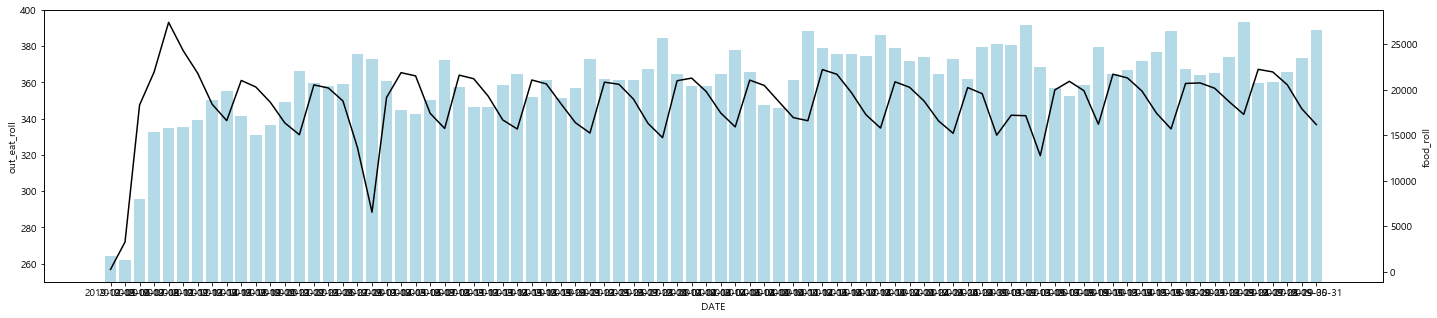

In [31]:
# 2019년 음식 물류 송장건수와 외식 카드 이용건수 간의 상관관계
out_eat_h_2019['DATE'] = out_eat_h_2019['DATE'].astype('str')
food_h_2019['DATE'] = food_h_2019['DATE'].astype('str')

fig, ax = plt.subplots(figsize=(24,5))
sns.barplot(data = out_eat_h_2019, x = 'DATE', y = 'out_eat_roll',alpha = 0.7, color = 'skyblue', ax = ax)
ax.set_ylim(250, 400)

g = ax.twinx()
g = sns.lineplot(data = food_h_2019, x = 'DATE', y = 'food_roll', color = 'k')

In [32]:
# 2020년 음식 물류 송장건수와 외식 카드이용 간의 상관관계 => 외식
pd.merge(out_eat_h_2020[['DATE','out_eat_roll','out_eat_per_roll']], food_h_2020[['DATE','food_roll']], on='DATE').corr()

,out_eat_roll,out_eat_per_roll,food_roll
out_eat_roll,1.000000,0.043530,-0.546015
out_eat_per_roll,0.043530,1.000000,-0.198668
food_roll,-0.546015,-0.198668,1.000000


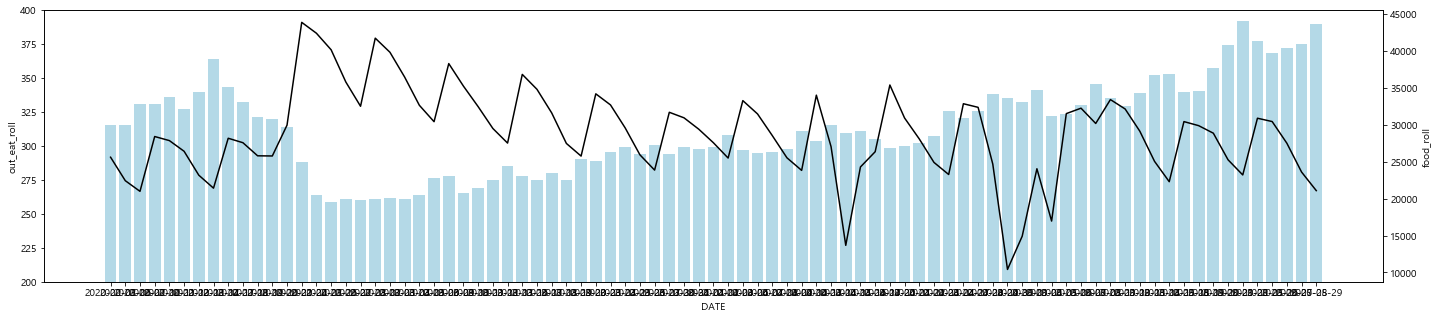

In [33]:
# 2020년 음식 물류 송장건수와 외식 카드이용 간의 상관관계
out_eat_h_2020['DATE'] = out_eat_h_2020['DATE'].astype('str')
food_h_2020['DATE'] = food_h_2020['DATE'].astype('str')

fig, ax = plt.subplots(figsize=(24,5))
sns.barplot(data = out_eat_h_2020, x = 'DATE', y = 'out_eat_roll',alpha = 0.7, color = 'skyblue', ax = ax)
ax.set_ylim(200, 400)

g = ax.twinx()
g = sns.lineplot(data = food_h_2020, x = 'DATE', y = 'food_roll', color = 'k')

In [34]:
# 2019년과 2020년 합산 음식 물류 송장건수와 외식 카드이용 간의 상관관계
pd.merge(out_eat_h[['DATE','out_eat_roll','out_eat_per_roll']], food_h[['DATE','food_roll']], on='DATE').corr()

,out_eat_roll,out_eat_per_roll,food_roll
out_eat_roll,1.000000,0.009825,-0.184500
out_eat_per_roll,0.009825,1.000000,0.005254
food_roll,-0.184500,0.005254,1.000000


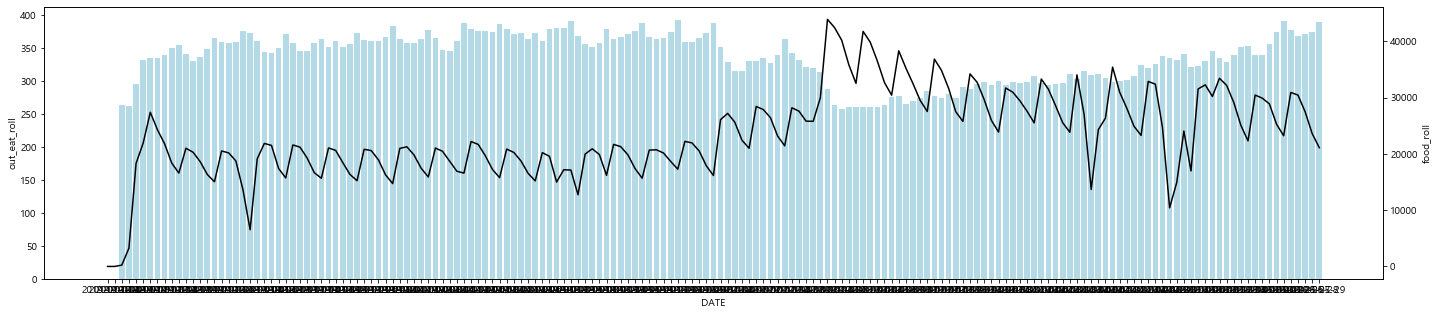

In [35]:
# 2019년과 2020년 합산 음식 물류 송장건수와 외식 카드이용 간의 상관관계
out_eat_h['DATE'] = out_eat_h['DATE'].astype('str')
food_h['DATE'] = food_h['DATE'].astype('str')

fig, ax = plt.subplots(figsize=(24,5))
sns.barplot(data = out_eat_h, x = 'DATE', y = 'out_eat_roll',alpha = 0.7, color = 'skyblue', ax = ax)
#ax.set_ylim(200, 400)

g = ax.twinx()
g = sns.lineplot(data = food_h, x = 'DATE', y = 'food_roll', color = 'k')

# Summary
- 코로나로 인해 외식이 감소하고, 배달 주문이 증가했다는 기사들이 많아 여기서는 택배 송장 건수로 비대면 음식물 섭취를 선호하는지 알아보려고 했음
- 상관계수 분석 결과, 2019년이나 2019+2020년에는 외식 방문건수와 음식 택배 송장건수 사이에 큰 상관성이 없었으나, **2020년에는 외식과 음식 송장 건수 간 상관계수가 -0.546이 나와 꽤 높은 음의 상관관계를 보여주고 있다.**
- 2020년에 음식 택배 송장건수가 폭발적으로 증가한 적이 있는 것은 사실이지만, 증감 폭이 작년보다 훨씬 크기 때문에 이 상황이 지속되리라는 보장은 없다.